In [1]:
#!pip install tensorflow==2.5.0
import math
from datetime import datetime
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import GlobalAveragePooling2D, Input, Dense, Activation
from tensorflow.keras.models import Model
from tensorflow.keras import initializers
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.mixed_precision import experimental as mixed_precision
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, accuracy_score, recall_score, precision_score, f1_score
import random as python_random

!pip install image-classifiers==1.0.0b1
!pip install keras-applications
from classification_models.tfkeras import Classifiers

You should consider upgrading via the '/usr/bin/python3.6 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3.6 -m pip install --upgrade pip' command.


In [2]:
np.random.seed(2021)
python_random.seed(2021)
tf.random.set_seed(2021)

In [3]:
mirrored_strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(mirrored_strategy.num_replicas_in_sync))

policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2
Your GPUs may run slowly with dtype policy mixed_float16 because they do not have compute capability of at least 7.0. Your GPUs:
  GeForce GTX 1080 Ti, compute capability 6.1 (x2)
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [4]:
#test_model = "saved_models/MIMIC-256x25660-10-30-split-resnet-Float16_2-race_detection_W2B_CXR_LR-0.001_20211214-130208_epoch:005_val_loss:0.17098.hdf5"
#test_model = "saved_models/MIMIC-256x25660-10-30-split-resnet-Float16_3-race_detection_CXR_LR-0.001_20211021-052440_epoch:016_val_loss:0.24378.hdf5"
#test_model = "saved_models/MIMIC-256x25660-10-30-split-resnet-Float16_2-race_detection_w2b_weigh_CXR_LR-0.001_20211222-062809_epoch:008_val_loss:0.13848.hdf5"
test_model = "saved_models/MIMIC-256x25680-20-split-resnet-Float16_2-race_detection_rop_seg_data_rop_seg-0.001_20220321-054140_epoch:011.hdf5"
#test_model = "saved_models/MIMIC-256x25680-20-split-resnet18-Float16_2-race_detection_rop_seg_data_rop_seg-0.001_20220322-174916_epoch:004.hdf5"

In [5]:
model = tf.keras.models.load_model(test_model)

In [6]:
import os
#gen0_10epoch_lrby2_bs8
ls = os.listdir("pytorch-CycleGAN-and-pix2pix-master/results/rop_seg_data_gfrozen5_lrby2/test_35_setA_white/images/")

In [7]:
ls.sort()

In [8]:
len(ls)

562

In [11]:
data = []
for i in range(len(ls)//2):
    data.append([ls[2*i], "WHITE"])
    data.append([ls[2*i+1], "BLACK/AFRICAN AMERICAN"])

In [12]:
combined = pd.DataFrame(data, columns=["path", "race"])

In [13]:
resnet34, preprocess_input = Classifiers.get('resnet34')
validate_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [14]:
test_batches = validate_gen.flow_from_dataframe(combined, directory = "pytorch-CycleGAN-and-pix2pix-master/results/rop_seg_data_gfrozen5_lrby2/test_35_setA_white/images/",x_col="path", y_col="race", class_mode="categorical",target_size=(256, 256),shuffle=False,batch_size=128, dtype='float32', interpolation='bilinear')

Found 562 validated image filenames belonging to 2 classes.


In [15]:
#with mirrored_strategy.scope():
multilabel_predict_test = model.predict(test_batches, max_queue_size=10, verbose=1, steps=math.ceil(len(combined)/128), workers=16)

5/5 [==============================] - 1s 227ms/step


In [16]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


In [17]:
len(multilabel_predict_test)

562

In [18]:
result = multilabel_predict_test
#result = model.predict(validate_batches, val_epoch)
labels = np.argmax(result, axis=1)
target_names = ['Black', 'White']

In [19]:
labels = np.argmax(result, axis=1)

In [22]:
predicted_white = []
predicted_black = []

for i in range(len(combined)//2):
    if labels[2*i+1]==1:
        predicted_white.append(i)
    elif labels[2*i+1]==0:
        predicted_black.append(i)

In [23]:
print("predicted_black - ", predicted_black)
print("predicted_white - ", predicted_white)

predicted_black -  [0, 1, 5, 9, 16, 22, 32, 37, 38, 41, 44, 54, 55, 75, 82, 93, 95, 98, 112, 113, 129, 130, 131, 134, 146, 149, 151, 156, 164, 169, 180, 181, 182, 184, 198, 200, 201, 205, 212, 214, 234, 236, 237, 259, 273]
predicted_white -  [2, 3, 4, 6, 7, 8, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 39, 40, 42, 43, 45, 46, 47, 48, 49, 50, 51, 52, 53, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 76, 77, 78, 79, 80, 81, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 94, 96, 97, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 132, 133, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 147, 148, 150, 152, 153, 154, 155, 157, 158, 159, 160, 161, 162, 163, 165, 166, 167, 168, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 183, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 199, 202, 203, 204, 206, 

In [21]:
74/179

0.4134078212290503

In [24]:
157/179

0.8770949720670391

In [129]:
236/281

0.8398576512455516

In [132]:
265/281

0.9430604982206405

In [150]:
139/179

0.776536312849162

In [153]:
162/179

0.9050279329608939

In [41]:
len(predicted_white)

28

In [42]:
len(predicted_black)

151

In [52]:
162/(162+17)

0.9050279329608939

In [22]:
real_predicted_white = []
fake_predicted_white = []
fake_predicted_black = []

for i in range(len(result)//2):
    real_predicted_white.append(result[2*i+1][1])
    fake_predicted_white.append(result[2*i][1])
    fake_predicted_black.append(result[2*i][0])

In [23]:
import statistics
print("real_predicted_white- "+str(statistics.mean(real_predicted_white)))
print("fake_predicted_white- "+str(statistics.mean(fake_predicted_white)))
print("fake_predicted_black- "+str(statistics.mean(fake_predicted_black)))

real_predicted_white- 0.98262364
fake_predicted_white- 0.49948698
fake_predicted_black- 0.500513


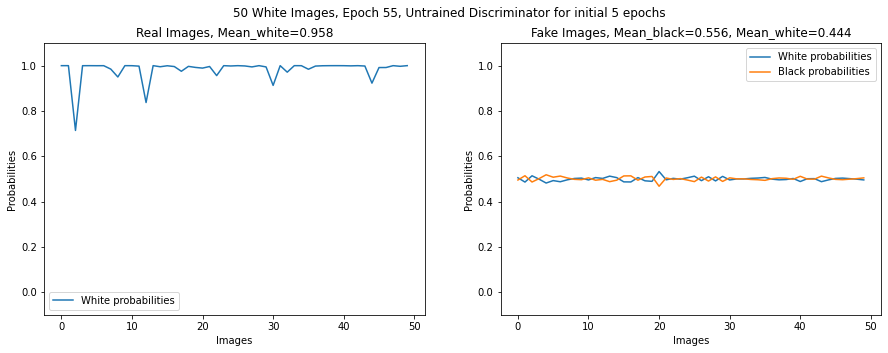

In [24]:
plt.figure(figsize=(15,5))
plt.suptitle("50 White Images, Epoch 55, Untrained Discriminator for initial 5 epochs")

plt.subplot(121), plt.title("Real Images, Mean_white=0.958")
plt.plot(real_predicted_white)
plt.xlabel("Images")
plt.ylabel("Probabilities")
plt.ylim(-0.1,1.1)
plt.legend(["White probabilities"])

plt.subplot(122), plt.title("Fake Images, Mean_black=0.556, Mean_white=0.444")
plt.plot(fake_predicted_white)
plt.plot(fake_predicted_black)
plt.xlabel("Images")
plt.ylim(-0.1,1.1)
plt.ylabel("Probabilities")
plt.legend(["White probabilities", "Black probabilities",])

In [25]:
labels = np.argmax(result, axis=1)

In [26]:
predicted_white = []
predicted_black = []

for i in range(50):
    if labels[2*i]==1:
        predicted_white.append(i)
    elif labels[2*i]==0:
        predicted_black.append(i)

In [27]:
print("predicted_black - ", predicted_black)
print("predicted_white - ", predicted_white)

predicted_black -  [1, 3, 4, 5, 6, 7, 10, 15, 16, 18, 19, 21, 23, 26, 28, 30, 31, 32, 36, 37, 38, 40, 43, 44, 48, 49]
predicted_white -  [0, 2, 8, 9, 11, 12, 13, 14, 17, 20, 22, 24, 25, 27, 29, 33, 34, 35, 39, 41, 42, 45, 46, 47]


In [109]:
len(predicted_white)

17

In [19]:
import matplotlib.pyplot as plt
import numpy as np

In [8]:
ls[:2]

['008a9e2d-12d54693-44c8caa1-6ef5d6a8-a39291ec_fake.png',
 '008a9e2d-12d54693-44c8caa1-6ef5d6a8-a39291ec_real.png']

In [9]:
ls[0]

'008a9e2d-12d54693-44c8caa1-6ef5d6a8-a39291ec_fake.png'

In [31]:
import cv2
path_fakeB = "pytorch-CycleGAN-and-pix2pix-master/results/gen0_5epoch_lrby2_bs8/test_30/images_white50_genA/1c50eb4e-cea17351-b9ba5502-b20d7a71-ea827c80_fake.png"
path_realA = "pytorch-CycleGAN-and-pix2pix-master/results/gen0_5epoch_lrby2_bs8/test_30/images_white50_genA/1c50eb4e-cea17351-b9ba5502-b20d7a71-ea827c80_real.png"
path_fakeA = "pytorch-CycleGAN-and-pix2pix-master/results/gen0_5epoch_lrby2_bs8/test_35/images_black50_genB/008a9e2d-12d54693-44c8caa1-6ef5d6a8-a39291ec_fake.png"
path_realB = "pytorch-CycleGAN-and-pix2pix-master/results/gen0_5epoch_lrby2_bs8/test_35/images_black50_genB/008a9e2d-12d54693-44c8caa1-6ef5d6a8-a39291ec_real.png"
#path_realA = "pytorch-CycleGAN-and-pix2pix-master/results/dislrby2_bs8/test_15/images/6b386bd8-a7aff797-97dfd9e7-bdf03f67-e1dd7870_real_A.png"
#path_realB = "pytorch-CycleGAN-and-pix2pix-master/results/dislrby2_bs8/test_15/images/6b386bd8-a7aff797-97dfd9e7-bdf03f67-e1dd7870_real_B.png"

img_fakeA = cv2.imread(path_fakeA, cv2.IMREAD_GRAYSCALE)
img_fakeA = cv2.resize(img_fakeA, (256,256))
img_fakeB = cv2.imread(path_fakeB, cv2.IMREAD_GRAYSCALE)
img_fakeB = cv2.resize(img_fakeB, (256,256))
img_realA = cv2.imread(path_realA, cv2.IMREAD_GRAYSCALE)
img_realA = cv2.resize(img_realA, (256,256))
img_realB = cv2.imread(path_realB, cv2.IMREAD_GRAYSCALE)
img_realB = cv2.resize(img_realB, (256,256))

In [32]:
image1= np.float32(img_fakeA)

image2= np.float32(img_realB)

diff_farb = image1 - image2

image1= np.float32(img_fakeB)

image2= np.float32(img_realA)

diff_fbra = image1 - image2